# Model validation: Mean wave direction stations

Note: this notebook requires the model output data

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Important Disclaimer</strong><br><br>
  This model setup is a <strong>simplified version</strong> of a detailed model developed by DHI. It does <strong>not</strong> resolve fine-scale processes and is <strong>not calibrated</strong> for operational use. Use is limited to <strong>educational and research purposes only</strong> — results should <strong>not</strong> inform decision-making. Performance shown here does <strong>not</strong> represent that of DHI’s high-resolution models.
</div>

### Import packages

In [95]:
import modelskill as ms
import matplotlib.pyplot as plt
import helper as h
import plotting as pl
import pandas as pd
from pathlib import Path
import mikeio

### Define metrics

Use circular metrics since the data is directional.

In [94]:
ms.options.metrics.list = ["c_bias", "c_rmse", "c_urmse", "c_mae", "cc", "si", "r2"]

Instead of reading the entire dfsu (`Area.dfsu`), we can simply load the outputted points (dfs0) since they correspond to the locations we have observations from.

### Define paths

In [ ]:
obs_fldr = "../observations/" 
meas_fldr = "../observations/measurements/" 
mr_fldr = "../output/"    
#mr_fldr = "../output_sample/"     # use this if you have not downloaded the full data from Zenodo yet

fig_fldr = "../figures/" 
save_fig = False if "sample" in mr_fldr else True
show_fig = True

### Load points data

Model results data are stored in a dfs0 file. We can use [MIKE IO](https://dhi.github.io/mikeio) read the data to a MIKE IO Dataset.

Note: The first two spin-up days are excluded.

In [91]:
ds = mikeio.read(f"{mr_fldr}Points.dfs0", items="*Mean Wave Direction*", time = slice("2022-01-03", None))

## Compare to mean wave direction observations

The [ModelSkill package](https://dhi.github.io/modelskill/) can be used to compare model results with observations.

In [ ]:
mwdlist = h.get_mwd_point_obs(obs_fldr=obs_fldr, meas_fldr=meas_fldr, station_file="stations.csv")

### Spatial coverage

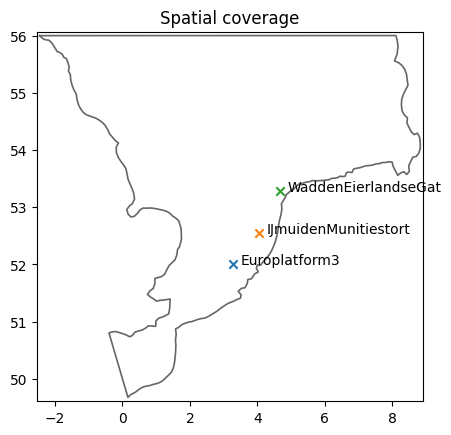

In [77]:
msh = mikeio.open("../input/Mesh_8000_elems.mesh")
ms.plotting.spatial_overview(mwdlist, mod=msh);

Match the right model result timeseries and observation.

In [98]:
mr_fn = f"{mr_fldr}Area.dfsu"
mr = ms.DfsuModelResult(mikeio.read(mr_fn,time=slice("2022-01-03","2023-12-31"))[3], name="MIKE21")

cmps = []
for o in mwdlist:
    print(f"Processing {o.name}...")
    mr = ms.PointModelResult(ds[o.name+": Mean Wave Direction"], name="MIKE21")
    try:
        cmp = ms.match(obs=o, mod=mr)
    except Exception as e:
        print("Station ", o.name)
        print(e)
    cmps.append(cmp)
cc = ms.ComparerCollection(cmps)

Processing Europlatform3...
Processing IJmuidenMunitiestort...
Processing WaddenEierlandseGat...


## Skill tables

In [99]:
cc.skill().round(3)

,n,c_bias,c_rmse,c_urmse,c_mae,cc,si,r2
observation,,,,,,,,
Europlatform3,8686,2.271,17.368,17.205,9.105,0.682,0.318,0.323
IJmuidenMunitiestort,100960,5.582,23.357,22.637,12.953,0.742,0.337,0.445
WaddenEierlandseGat,97083,3.858,23.047,22.699,12.500,0.790,0.323,0.577


In [100]:
cc.mean_skill().round(3)

,n,c_bias,c_rmse,c_urmse,c_mae,cc,si,r2
model,,,,,,,,
MIKE21,206729,3.904,21.257,20.847,11.519,0.738,0.326,0.448


## Scatter plots

Text(0.5, 1.0, 'MIKE21 vs Observations')

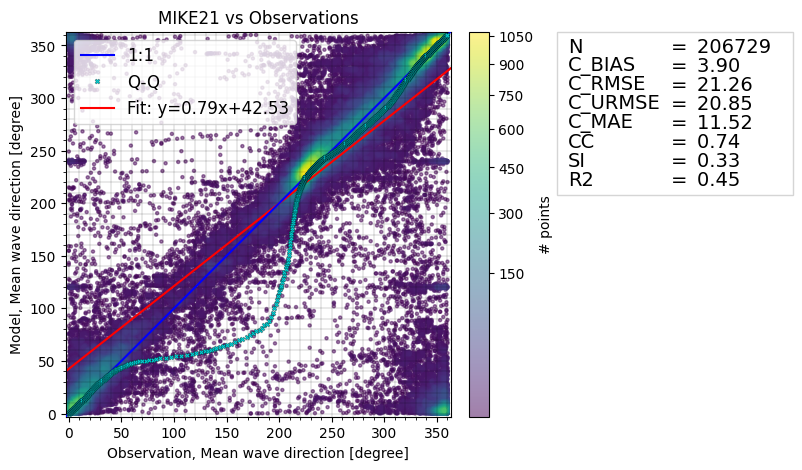

In [103]:
# TODO, ikke cirkulært data??
cc.plot.scatter(skill_table=True, show_points=True, figsize=(6,5))
plt.title("MIKE21 vs Observations")

fig saved to: ../figures/mean_wave_direction_comparison_Europlatform3.png


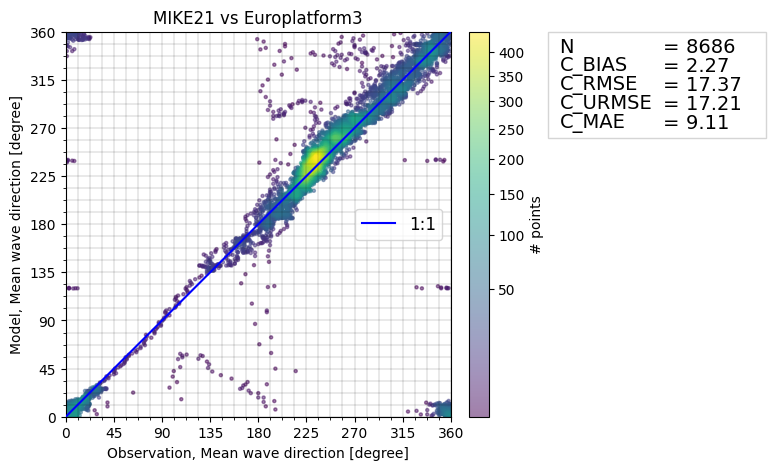

fig saved to: ../figures/mean_wave_direction_comparison_IJmuidenMunitiestort.png


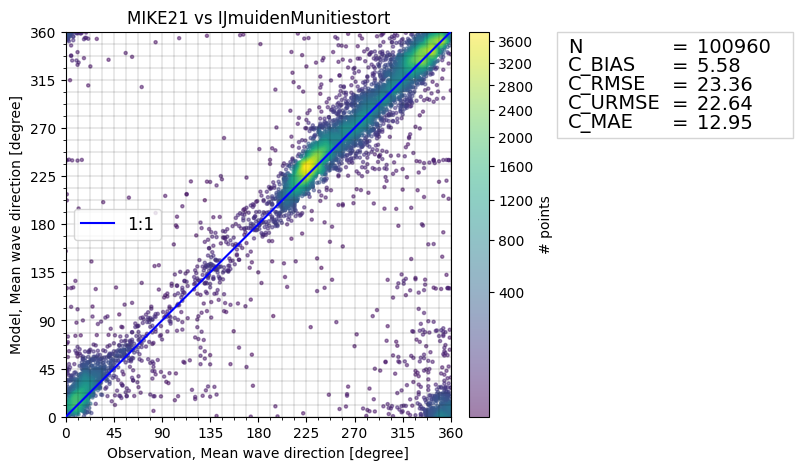

fig saved to: ../figures/mean_wave_direction_comparison_WaddenEierlandseGat.png


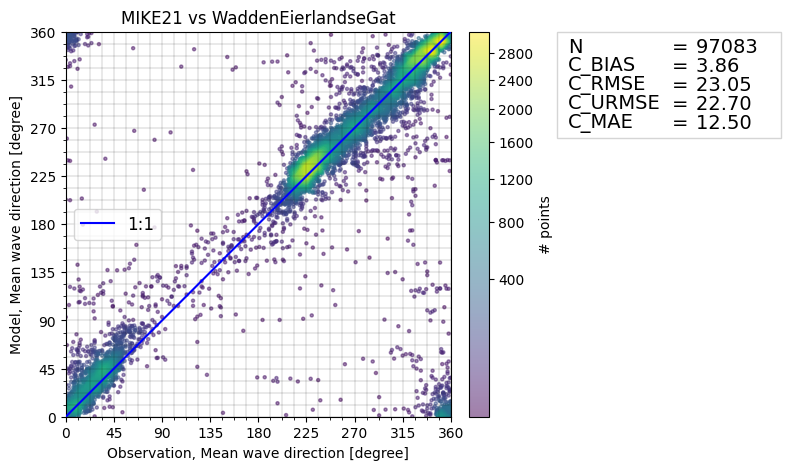

In [102]:
n_points_shown = 10000
for cmp in cc:
    cmp.plot.scatter(skill_table=True, show_points=n_points_shown, figsize=(6,5), bins=40);
    if save_fig:
        plt.savefig(f"{fig_fldr}mean_wave_direction_comparison_{cmp.name}.png", bbox_inches='tight');
        print(f"fig saved to: {fig_fldr}mean_wave_direction_comparison_{cmp.name}.png")
    if show_fig:
        plt.show()
    else:
        plt.close()

## KDE plot

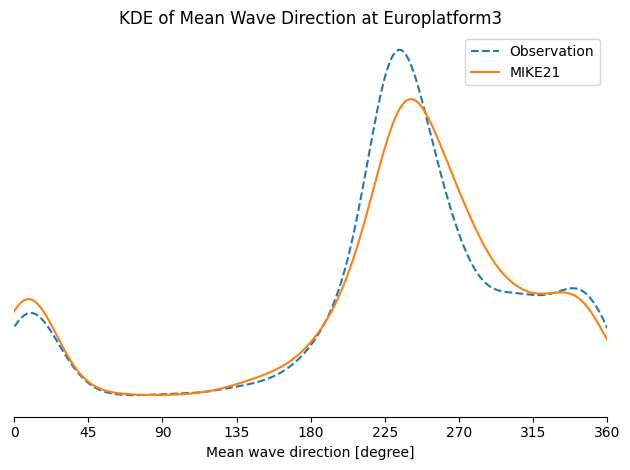

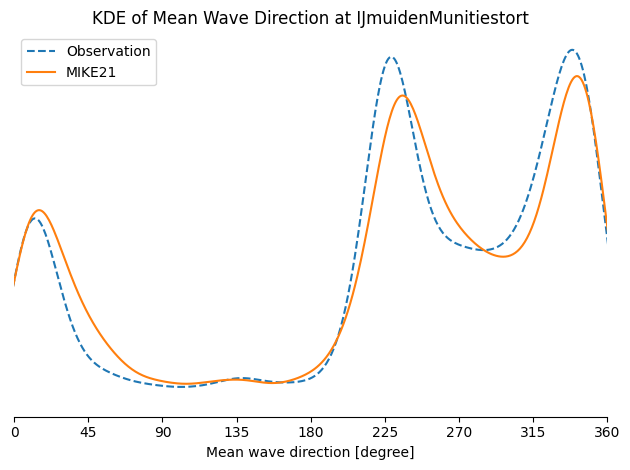

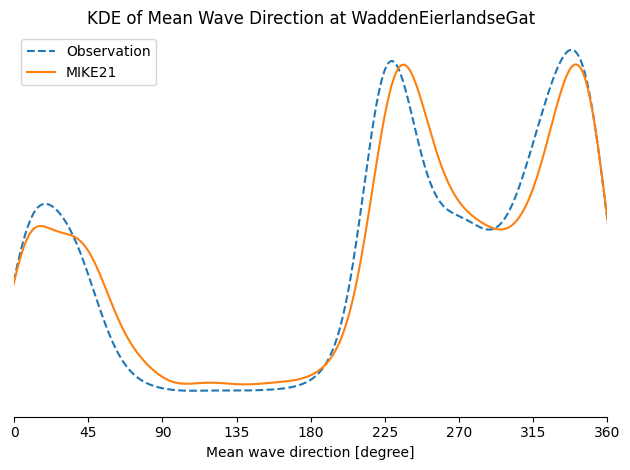

In [106]:
for cmp in cc:
    ax = cmp.plot.kde(xlim=(0, 360))
    ax.set_title(f"KDE of Mean Wave Direction at {cmp.name}")
    plt.tight_layout()
plt.show()